In [1]:
import pystac_client
import planetary_computer
import rasterio
import rasterio.features
import numpy as np
import xrspatial.multispectral as ms
from odc.stac import stac_load
from rasterio.plot import show
from joblib import  load
from rasterio.plot import show
import features
from rasterio.plot import reshape_as_raster, reshape_as_image
import processing
import xarray
import folium

# Loading data from Planetary Computer


This part isn't too important. Alternatively images can be loaded from a filesystem, or from a S3 link with rioxarray (not included in this notebook:

```python

data_array = rioxarray.open_rasterio(s3_link, chunks=True)
data_array_file = rioxarray.open_rasterio(file, chunks=True)

```

Below, we are downloading the imagery from planetary computer, an imaging and computing service provided by microsoft

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": 
    [[[-77.23526000976562, 17.753479383833962], 
      [-77.23526000976562, 17.793735796697966], 
      [-77.13706970214845, 17.793735796697966], 
      [-77.13706970214845, 17.753479383833962], 
      [-77.23526000976562, 17.753479383833962]]]
}

bbox = rasterio.features.bounds(area_of_interest)

In [3]:
time_of_interest = "2022-03-01/2022-04-01"

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                 modifier=planetary_computer.sign_inplace,)

search = stac.search(bbox=bbox, datetime=time_of_interest, collections=["sentinel-2-l2a"], 
                     query={"eo:cloud_cover": {"lt": 25}},)

items = search.item_collection()

cfg = {
    "sentinel-2-l2a": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
    },
    "*": {"warnings": "ignore"},
}

xx = stac_load(
    items,
    bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
       'B11', 'B12'],
    resolution=10,
    bbox = bbox,
    chunks={"x": 256, "y": 256},
    stac_cfg=cfg,
    patch_url=planetary_computer.sign,
)

median = xx.median(dim="time").compute()

C:\Users\hicks\anaconda3\envs\gdal\lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
C:\Users\hicks\anaconda3\envs\gdal\lib\site-packages\rasterio\warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [4]:
# Writing input image to .tif file
median.to_array().odc.write_cog(
    'example_input_image.tif',
    overwrite=True
)

WindowsPath('example_input_image.tif')

# Adding Features

Here, we are adding features to the input images, which is very easy. This will be different depending on the data given, but assuming we have Sentinel 2A imagery, the process is the following: 

In [5]:
# This simulates the 'feature engineering' portion of the classification service

median['ndvi'] = features.s2_ndvi(median)
median['nvwi'] = features.s2_ndwi(median)
median['water_dist'] = features.s2_distance_to_water(median, threshold = 0)

Tree build time: 0.0359 seconds
Distance calc run time: 10.8897 seconds


In [6]:
# Writing processed image to .tif file

median.to_array().odc.write_cog(
    'example_processed_image.tif',
    overwrite=True
)

WindowsPath('example_processed_image.tif')

# Formatting Data

Here, we can get the image and flatten it to what amounts to a flattened array of pixels

In [7]:
img = reshape_as_image(median.to_array().to_numpy())

# This array can then be sent over, in chunks to the classification service
array = img.reshape(img.shape[0] * img.shape[1], img.shape[2])

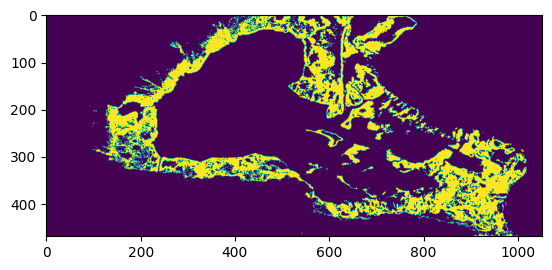

<Axes: >

In [8]:
# With the model loaded using joblib, we can then classify each pixel

clf = load('ex_classifier.joblib') 
output = clf.predict(array)

# The output chunks can then be reformed to an image on the processing service
output_img = reshape_as_raster(output.reshape(img.shape[0], img.shape[1], 1))
show(output_img)

In [9]:
# This is just to save the example image
label_array = xarray.DataArray(np.squeeze(output_img), coords={'y': median.coords['y'],'x': median.coords['x'], 
                                          'spatial_ref': median.coords['spatial_ref']}, 
                                          dims=["y", "x"])
label_array.odc.write_cog(
    'example_label_array.tif',
    overwrite=True
)

WindowsPath('example_label_array.tif')

In [10]:
from rasterio.features import shapes
import geopandas as gpd
import processing

# Now, we can then use the bounds of the original image and transform the labels into a geojson
transform = rasterio.transform.from_bounds(*bbox, width= output_img.shape[2], height= output_img.shape[1])
labels = processing.raster_to_gdf(output_img, transform, crs = "EPSG:32617")

# Saving GeoJSON
labels.to_file('labels.geojson', driver='GeoJSON')  

In [11]:
#Visualizing the GeoJSON

m = folium.Map(location=[17.81, -77.25], zoom_start=12, tiles='CartoDB positron')

for r in labels:
    sim_geo = gpd.GeoSeries(r)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data = geo_j, style_function = lambda x: {'fillColor': 'green', "weight": 1})
    geo_j.add_to(m)
m